----
# Hava Kalitesini İzleme.
----

Bu iş akışı, toplam sütun ozon konsantrasyonunu tahmin etmek için **Sentinel-5P/TROPOMI** verilerine dayalı bir sinir ağı eğitimi sürecinde bize rehberlik edecek. Kullanacağımız veri 29 Aralık 2018'de Sicilya (İtalya) üzerinden alınan bir Sentinel-5P/TROPOMI sahnesine ait etiketli veri tabanı.

Kullanacağmız veri 2500 satır girişi ve 26 sütun içerir. 2500 sıra, Sicilya, İtalya genelinde 2500 nokta konumuna benzer. 26 sütun aşağıdaki bilgileri temsil eder:

* Sütun 1-21: Ozon kolonu bolluğuna duyarlı 21 dalga boyu [rad_325.0_nm, rad_335.0_nm] için spektral parlaklık değeri ve TROPOMI Düzey-1B Bant-3 ürününden türetilmiştir

* Sütun 22: TROPOMI Level-1B Band-3 ürününden türetilen solar zenit açısı [sza]

* Sütun 23: TROPOMI Level-1B Band-3 ürününden türetilen sensör zenit açısı [vza]

* Sütun 24: enlem [enlem]

* Sütun 25: boylam [lon]

* Sütun 26: TROPOMI Düzey-2 Toplam Sütun Ozon ürününden türetilen Toplam Ozon sütunu bolluğu [ozone_total_column_[DU]]

In [1]:
# 1. Kütüphanelerimizi İmport Edelim..

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np

## Model Eğitimi için Girdi ve Çıktı Verilerini Hazırlayalim..

#### Eğitim Veri Kümesini Yüklemek..
İlk aşama olarak verilen bir csv dosyasını kullanarak çalişma ortamımıza yüklemek olacak. Çalişacağımız veri 2500 nokta/konum ve 26 sütun içeriyor.  Yukarıda bu veriyle alakali bilgi verdik.

In [2]:
# 2. Verileri Yükleyelim
dataset= pd.read_csv('C:\\Users\\ernsb\\Desktop\\AIFOR\\atmosfer verileri\\AI4EO_Ozone_Estimation_Sentinel-5p.csv')
dataset

,rad_325.0_nm,rad_325.5_nm,rad_326.0_nm,rad_326.5_nm,rad_327.0_nm,rad_327.5_nm,rad_328.0_nm,rad_328.5_nm,rad_329.0_nm,rad_329.5_nm,...,rad_333.0_nm,rad_333.5_nm,rad_334.0_nm,rad_334.5_nm,rad_335.0_nm,sza,vza,lat,lon,ozone_total_column_[DU]
0,0.042720,0.052927,0.064092,0.066062,0.062508,0.059063,0.054011,0.055656,0.072492,0.076385,...,0.066981,0.058454,0.064113,0.068836,0.067544,59.516346,7.200823,34.040398,15.452229,312.801062
1,0.035083,0.043096,0.052921,0.054148,0.052210,0.049266,0.044553,0.045935,0.058220,0.062203,...,0.053694,0.047931,0.050669,0.055808,0.052929,58.856736,10.524595,33.157636,16.177355,311.510057
2,0.032866,0.039644,0.050325,0.050918,0.050511,0.047489,0.042784,0.044021,0.054030,0.059267,...,0.050887,0.047117,0.047478,0.054090,0.049683,60.072235,14.218850,34.355670,16.398046,310.450920
3,0.034466,0.042574,0.051158,0.052547,0.049777,0.046973,0.042978,0.044233,0.057255,0.060181,...,0.052075,0.045585,0.049813,0.053308,0.052190,60.109164,6.403538,34.733997,15.136957,307.712248
4,0.031162,0.038639,0.046340,0.047647,0.045056,0.042522,0.038951,0.040127,0.052197,0.054791,...,0.047542,0.041568,0.045608,0.048783,0.047797,62.851804,5.198928,37.823663,14.033505,296.586119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.035029,0.034219,0.046429,0.051954,0.053398,0.049628,0.048426,0.044431,0.047056,0.057794,...,0.054243,0.053478,0.045803,0.053406,0.055708,62.746115,26.651324,36.751738,17.785243,300.032216
2496,0.028071,0.034575,0.041262,0.042478,0.039951,0.037723,0.034540,0.035691,0.046237,0.048472,...,0.041648,0.036282,0.040008,0.042476,0.041984,62.784141,4.876854,37.760609,14.001978,296.118841
2497,0.033929,0.041685,0.052090,0.053287,0.051815,0.048783,0.043879,0.045482,0.057710,0.062159,...,0.054260,0.048758,0.050999,0.056917,0.053629,63.468435,11.365543,38.265044,14.853213,302.393093
2498,0.031069,0.038370,0.045653,0.047141,0.044044,0.041472,0.038281,0.039707,0.051756,0.054031,...,0.046890,0.040487,0.045092,0.047425,0.047548,63.734396,2.560235,38.895588,13.276852,304.393545


### Girdi - Çıktı Verilerini Ayarlayalim
Bir sonraki adımda, sinir ağı modelinin giriş (X) ve çıkış (y) değişkenleri olarak hizmet edecek yüklü veri kümesinin sütunlarını ve satırlarını tanımlarsınız. 21 dalga boyu için spektral ışıma değerlerinin yanı sıra güneş ve sensör zenit açılarını içeren ilk 23 sütun, giriş (X) değişkenleri olarak hizmet edecektir. Toplam sütun ozon bilgisi, modelin tahmin edebileceği çıktı (y) değişkeni olarak hizmet eder.

In [3]:
# 3. Girdi ve Çıktı Verilerini Belirliyoruz..
X = dataset.values[:, 0:23]
y = dataset.values[:, 25:26]

X.shape, y.shape

((2500, 23), (2500, 1))

#### Veri Kümesini Train-Test-Validation Kümelerine Ayırma..
Artık eğitim, doğrulama ve test için girdi ve çıktı değişkenlerini alt kümelere ayırabilirsiniz.

* Training Data : Bu Makine Öğrenimi modelini eğitmek için kullanılan gerçek örnektir.
* Validation Data : Doğrulama Verileri, model hiperparametreleri ayarlanırken modelin egitim verilerine ne kadar uydugunu değerlendirmek için kullanılır. Ancak model bu verilerden öğrenmez .
* Test Data : Nihai model uygunluğunun bir değerlendirmesini sağlamak için kullanılır ve bu veriler yalnızca bir model eğitim ve doğrulama verilerine dayalı olarak tamamen eğitildiğinde kullanılır.

In [4]:
# 4. Test-Train Olarak Bölmek..
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.33, 
                                                                    random_state=42)

X_train.shape, X_val_and_test.shape, y_train.shape, y_val_and_test.shape

((1675, 23), (825, 23), (1675, 1), (825, 1))

In [5]:
# 5. Doğrulama Belirleyelim..
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, 
                                                y_val_and_test, 
                                                test_size=0.45, 
                                                random_state=42)

X_val.shape, X_test.shape, y_val.shape, y_test.shape

((453, 23), (372, 23), (453, 1), (372, 1))

### Giriş ve Çıkış Verilerinin Normalleştirilmesi

Bir sonraki adım, giriş ve çıkış verilerini normalleştirmektir. Normalleştirme, farklı birimlerde ölçülen değişkenleri ortak bir ölçeğe getirmek için Makine Öğreniminde ortak bir ön işleme adımıdır. Normalleştirme, tüm Makine Öğrenimi algoritmaları için gerekli değildir, ancak sinir ağları için kritik öneme sahiptir.

Giriş ve çıkış değişkenlerini ölçeklendirmek için scikit-learn kitaplığından MinMaxScalerclass'ı kullanabilirsiniz. Özellik_aralığı'nın minimum ve maksimum sınırlarını anahtar kelime argümanı olarak belirleyebilirsiniz.

Giriş ve çıkış verileri için sırasıyla farklı özellik aralıklarına sahip iki MinMaxScaler nesnesi tanımlayalım:
* input_scaler: [-5, 5]
* output_scaler: [0, 1]

**NOT!..**

Özellik aralığı, sinir ağındaki her bir nöron için kullanılan sigmoidal aktivasyon fonksiyonuna göre ayarlanır. Giriş ve çıkış özellikleri, fonksiyon etki alanına ve ortak etki alanına göre ölçeklenir.


In [6]:
# 6. Normalleştirilme İşlemleri..
input_scaler = MinMaxScaler(feature_range=(-5, 5))
output_scaler = MinMaxScaler(feature_range=(0, 1))

# 7. Normalleştirme İşlemlerini Uyguluyoruz..
input_scaler.fit(X)
X_train_scaled = input_scaler.transform(X_train)
X_val_scaled = input_scaler.transform(X_val)
X_test_scaled = input_scaler.transform(X_test)

# with the output scaler we fit all the output space and then scale each splitted part of the dataset used as output for the neural network
output_scaler.fit(y)
y_train_scaled = output_scaler.transform(y_train)
y_val_scaled = output_scaler.transform(y_val)

**NOT!.**

Eğitim aşamasında test verisi alt kümesini kullanmadığımız için y_test değişkenini ölçeklendirmeye gerek yoktur. Doğruluk puanlarını tahmin etmek için onların ağın çıktısıyla karşılaştırmak için yalnızca orijinal ölçekteki verilere ihtiyacımız var.

## Keras İle Sıralı Bir Sinir Ağı Tanımlayip , Derleyelim.

Epoch 1/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0391 - mae: 0.1646 - val_loss: 0.0323 - val_mae: 0.1532
Epoch 2/300
168/168 [==============================] - 0s 871us/step - loss: 0.0332 - mae: 0.1523 - val_loss: 0.0289 - val_mae: 0.1444
Epoch 3/300
168/168 [==============================] - 0s 710us/step - loss: 0.0301 - mae: 0.1445 - val_loss: 0.0267 - val_mae: 0.1378
Epoch 4/300
168/168 [==============================] - 0s 760us/step - loss: 0.0281 - mae: 0.1384 - val_loss: 0.0252 - val_mae: 0.1336
Epoch 5/300
168/168 [==============================] - 0s 746us/step - loss: 0.0267 - mae: 0.1344 - val_loss: 0.0241 - val_mae: 0.1296
Epoch 6/300
168/168 [==============================] - 0s 687us/step - loss: 0.0256 - mae: 0.1308 - val_loss: 0.0233 - val_mae: 0.1265
Epoch 7/300
168/168 [==============================] - 0s 707us/step - loss: 0.0248 - mae: 0.1282 - val_loss: 0.0227 - val_mae: 0.1244
Epoch 8/300
168/168 [==============================] - 0s

Epoch 119/300
168/168 [==============================] - 0s 695us/step - loss: 0.0175 - mae: 0.1040 - val_loss: 0.0169 - val_mae: 0.1007
Epoch 120/300
168/168 [==============================] - 0s 926us/step - loss: 0.0175 - mae: 0.1041 - val_loss: 0.0169 - val_mae: 0.1006
Epoch 121/300
168/168 [==============================] - 0s 760us/step - loss: 0.0175 - mae: 0.1040 - val_loss: 0.0168 - val_mae: 0.1006
Epoch 122/300
168/168 [==============================] - 0s 695us/step - loss: 0.0175 - mae: 0.1038 - val_loss: 0.0168 - val_mae: 0.1005
Epoch 123/300
168/168 [==============================] - 0s 813us/step - loss: 0.0175 - mae: 0.1038 - val_loss: 0.0168 - val_mae: 0.1006
Epoch 124/300
168/168 [==============================] - 0s 867us/step - loss: 0.0174 - mae: 0.1038 - val_loss: 0.0168 - val_mae: 0.1003
Epoch 125/300
168/168 [==============================] - 0s 847us/step - loss: 0.0174 - mae: 0.1037 - val_loss: 0.0168 - val_mae: 0.1005
Epoch 126/300
168/168 [==================

Epoch 179/300
168/168 [==============================] - 0s 727us/step - loss: 0.0162 - mae: 0.1007 - val_loss: 0.0156 - val_mae: 0.0972
Epoch 180/300
168/168 [==============================] - 0s 745us/step - loss: 0.0162 - mae: 0.1007 - val_loss: 0.0156 - val_mae: 0.0971
Epoch 181/300
168/168 [==============================] - 0s 739us/step - loss: 0.0162 - mae: 0.1005 - val_loss: 0.0156 - val_mae: 0.0974
Epoch 182/300
168/168 [==============================] - 0s 762us/step - loss: 0.0162 - mae: 0.1005 - val_loss: 0.0155 - val_mae: 0.0970
Epoch 183/300
168/168 [==============================] - 0s 787us/step - loss: 0.0162 - mae: 0.1005 - val_loss: 0.0155 - val_mae: 0.0970
Epoch 184/300
168/168 [==============================] - 0s 726us/step - loss: 0.0161 - mae: 0.1005 - val_loss: 0.0155 - val_mae: 0.0972
Epoch 185/300
168/168 [==============================] - 0s 758us/step - loss: 0.0161 - mae: 0.1004 - val_loss: 0.0155 - val_mae: 0.0970
Epoch 186/300
168/168 [==================

Epoch 239/300
168/168 [==============================] - 0s 809us/step - loss: 0.0152 - mae: 0.0977 - val_loss: 0.0146 - val_mae: 0.0943
Epoch 240/300
168/168 [==============================] - 0s 783us/step - loss: 0.0152 - mae: 0.0977 - val_loss: 0.0146 - val_mae: 0.0942
Epoch 241/300
168/168 [==============================] - 0s 768us/step - loss: 0.0152 - mae: 0.0977 - val_loss: 0.0146 - val_mae: 0.0942
Epoch 242/300
168/168 [==============================] - 0s 725us/step - loss: 0.0152 - mae: 0.0976 - val_loss: 0.0145 - val_mae: 0.0939
Epoch 243/300
168/168 [==============================] - 0s 789us/step - loss: 0.0152 - mae: 0.0975 - val_loss: 0.0145 - val_mae: 0.0943
Epoch 244/300
168/168 [==============================] - 0s 828us/step - loss: 0.0151 - mae: 0.0975 - val_loss: 0.0145 - val_mae: 0.0940
Epoch 245/300
168/168 [==============================] - 0s 735us/step - loss: 0.0151 - mae: 0.0974 - val_loss: 0.0145 - val_mae: 0.0938
Epoch 246/300
168/168 [==================

Epoch 299/300
168/168 [==============================] - 0s 683us/step - loss: 0.0145 - mae: 0.0954 - val_loss: 0.0139 - val_mae: 0.0919
Epoch 300/300
168/168 [==============================] - 0s 679us/step - loss: 0.0145 - mae: 0.0953 - val_loss: 0.0139 - val_mae: 0.0920
Training time  39.386 s


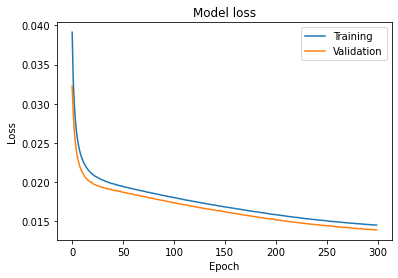

In [7]:
# 8 Keras İşlemlerine Başliyoruz..
model_nn_for_o3 = Sequential([Dense(units=20, 
                                    activation='sigmoid', 
                                    input_shape=(23,)),
                              Dense(units=1, 
                                    activation='sigmoid')])

model_nn_for_o3.compile(optimizer='sgd',  
                        loss='mean_squared_error',  
                        metrics=['mae'])

# 9 Training (fitting) İşlemleri..
start_training = time.time()

hist = model_nn_for_o3.fit(X_train_scaled, 
                           y_train_scaled, 
                           batch_size=10, 
                           epochs=300, 
                           validation_data=(X_val_scaled, y_val_scaled), 
                           verbose=1)

end_training = time.time()
print("Training time ", round((end_training - start_training), 3), "s" )

# 10 Görselleştirme Aşamaları..
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

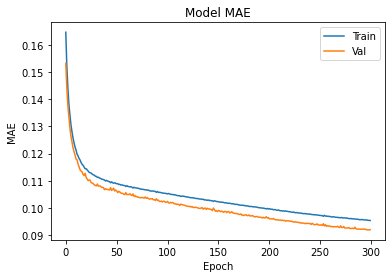

In [8]:
# 11.
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Eğitim Sürecini Değerlendirme İşlemi..

Eğitim sürecinin yararlı bir değerlendirmesi, eğitim dönemleri sırasında kayıp fonksiyonunu ve ortalama mutlak hatayı çizmektir. Her iki metriğin azalan bir eğilimi, ağın öğrenme kabiliyetini gösterir. **Kayıp ve val_loss ölçümlerini** çizerek eğitim dönemleri sırasında kayıp fonksiyonunu çizin.

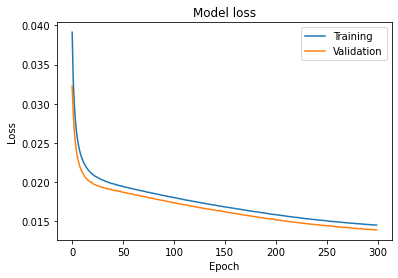

In [9]:
# 12. Kayıp ve Val_loss Ölçümleri

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### mae ve val_mae metriklerini çizerek eğitim dönemleri sırasında ortalama mutlak hatayı çizin.

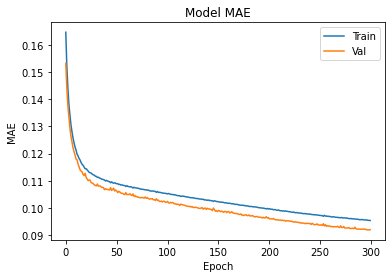

In [10]:
# 13. Mae ve Val_Mae Çiziyoruz..
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

###  Toplam Sütun Ozon Tahminlerini Tahmin Etmek için Eğitilmiş Sıralı Sinir Ağını Kullanma

Artık X_train_scaled, X_val_scaled ve X_test_scaled girdi veri alt kümelerini temel alarak total_column_ozone çıktı değişkenini tahmin etmek için eğitilmiş modeli kullanıcaz. Bunu yapmak için **model.predict()** işlevini kullanabilirsiniz. Sonuç, tahmin edilen total_column_ozone'dur, ancak yine de normalleştirilmiş/dönüştürülmüş biçimdedir. Bu nedenle, bir sonraki adımda dönüşümü tersine çevirmeliyiz.

**Not**

Eğitim ve doğrulama verilerinin doğruluğunun tahmini, test verilerinde elde edilenlerle karşılaştırılabilir. Bu bize eğitim sırasında dikkate alınmayan veriler üzerinden ağ performansını genellediğimizde hatanın varyasyonu hakkında bilgi verir.

In [11]:
# 14..
predict_train = model_nn_for_o3.predict(X_train_scaled)
predict_val = model_nn_for_o3.predict(X_val_scaled)
predict_test = model_nn_for_o3.predict(X_test_scaled)
predict_train

array([[0.6784275 ],
       [0.3743291 ],
       [0.415729  ],
       ...,
       [0.32918137],
       [0.68329036],
       [0.6604594 ]], dtype=float32)

**MinMaxScaler sınıfı,** normalleştirme sürecini tersine çevirmenize izin veren **inverse_transform()** adlı bir işleve sahiptir. İşlev, normalleştirilmiş tahmini değerleri alır ve **Dobson Birimi (DU)** cinsinden dönüştürülmüş toplam sütun ozon tahminlerini döndürür.

**Dobson Birimi (DU),** ozon hacminin yaklaşık milyarda bir kısmının ortalama atmosferik konsantrasyonunu ifade eder. 

In [12]:
# 15..
predict_train_inverse = output_scaler.inverse_transform(predict_train)
predict_val_inverse = output_scaler.inverse_transform(predict_val)
predict_test_inverse = output_scaler.inverse_transform(predict_test)
predict_train_inverse

array([[309.7322 ],
       [302.33176],
       [303.33926],
       ...,
       [301.2331 ],
       [309.85052],
       [309.29492]], dtype=float32)

In [14]:
# 16 Modeli Kayıt Etmek İstersek..
model_nn_for_o3.save("C:\\Users\\ernsb\Desktop\\AIFOR\\atmosfer verileri\\model_nn_for_o3.h5")

### Model Tahminlerinin Doğruluğunu Değerlendirme
Son adım olarak eğitilmiş modelimizin doğruluğunu değerlendirmek isteriz. Regresyon problemlerinin performans değerlendirmesine uygun farklı metrikler vardır. Bu iş akışı için *mutlak hata, ortalama kare hata ve Pearson's Korelasyon Katsayısı* metriklerine odaklanacağız..

In [15]:
# 17. Mean Absolute Error İşlemleri..
mae_train = mean_absolute_error(y_train, predict_train_inverse)
mae_val = mean_absolute_error(y_val, predict_val_inverse)
mae_test = mean_absolute_error(y_test, predict_test_inverse)

print(f'Train MAE: {round(mae_train, 3)} DU, Val MAE: {round(mae_val, 3)} DU, Test MAE: {round(mae_test, 3)} DU')

Train MAE: 2.318 DU, Val MAE: 2.238 DU, Test MAE: 2.413 DU


In [16]:
# 18. Mean Squared Error İşlemleri..
rmse_train = mean_squared_error(y_train, predict_train_inverse, squared=False)
rmse_val = mean_squared_error(y_val, predict_val_inverse, squared=False)
rmse_test = mean_squared_error(y_test, predict_test_inverse, squared=False)

print(f'Train RMSE: {round(rmse_train, 3)} DU, Val RMSE: {round(rmse_val, 3)} DU, Test RMSE: {round(rmse_test, 3)} DU')

Train RMSE: 2.925 DU, Val RMSE: 2.867 DU, Test RMSE: 3.001 DU


In [17]:
# 19. Pearson Korelasyon Katsayısı..
pearson_train = np.sqrt(r2_score(y_train, predict_train_inverse))
pearson_val = np.sqrt(r2_score(y_val, predict_val_inverse))
pearson_test = np.sqrt(r2_score(y_test, predict_test_inverse))

print(f'Train Pearson: {round(pearson_train, 3)}, Val Pearson: {round(pearson_val, 3)}, Test Pearson: {round(pearson_test, 3)}')

Train Pearson: 0.819, Val Pearson: 0.811, Test Pearson: 0.795


Son bir değerlendirme performansı olarak, tahmini ve gerçek toplam sütun ozon değerlerinin ortalama ve standart sapmasını (std) karşılaştıralım.

In [18]:
# 20. Standart Sapma..
print("\n" "Evaluation of mean and standard deviation of the estimated values of ozone total column compared to the actual ones")
print(f'Ozone Total Column true mean: {round(np.mean(y_test), 3)} DU --- Ozone Total Column estimated mean: {round(float(np.mean(predict_test_inverse)), 3)} DU')
print(f'Ozone Total Column true std: {round(np.std(y_test), 3)} DU --- Ozone Total Column estimated std: {round(float(np.std(predict_test_inverse)), 3)} DU')


Evaluation of mean and standard deviation of the estimated values of ozone total column compared to the actual ones
Ozone Total Column true mean: 306.44 DU --- Ozone Total Column estimated mean: 305.988 DU
Ozone Total Column true std: 4.942 DU --- Ozone Total Column estimated std: 3.895 DU


Performansı değerlendirmek için, ortalama mutlak hatayı (MAE) ve test verisi alt kümesindeki ortalamayı karşılaştırabiliriz. Test verileri için MAE çok daha yüksektir. Diğer bir olasılık, ortalama karesel hatanın (RMSE) standart sapma ("ortalama" tahmin ediciyi temsil eden) ile karşılaştırmaktır. Mevcut iş akışında standart sapmaya göre RMSE'de önemli bir azalma elde edebileceğimizi görebilirsiniz.